Run this cell first, and modify the `DIRECTORY` string as necessary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DIRECTORY = '/content/drive/MyDrive/2021_a_final/Github'

Mounted at /content/drive


# Licenses


In [ ]:
#@title ##### GraphNets License { form-width: "50%" }
# Copyright 2018 The GraphNets Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

In [ ]:
#@title ##### Modified Notice - MCMB Lab { form-width: "50%" }
# The GraphNets framework has been modified by:
# Multiscale Computational Mechanics and Biomechanics LAB (MCMB Lab)
# Department of Mechanical Engineering and Mechanics
# Drexel University, Philadelphia, Pennsylvania 
# Diroctor: Ahmad Raeisi Najafi (Ph.D.)
# All rights reserved.
# Developer: Nolan Black 10/2020
# Created in: 10/2020
# Last modified in: 12/2020
# ============================================================================

# Load Functions

In [ ]:
FUNCTIONS = '{}/Functions.ipynb'.format(DIRECTORY)
%run $FUNCTIONS

Installing Graph Nets library and dependencies:
Output message from command:

     |████████████████████████████████| 76 kB 2.9 MB/s 
     |████████████████████████████████| 411.0 MB 23 kB/s 
     |████████████████████████████████| 665 kB 53.7 MB/s 
     |████████████████████████████████| 2.5 MB 54.8 MB/s 
     |████████████████████████████████| 20.1 MB 330 kB/s 
     |████████████████████████████████| 3.8 MB 40.7 MB/s 
     |████████████████████████████████| 2.9 MB 45.7 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 503 kB 43.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=59a553e4e51ebb54f890d9c65b875774bf450f37a98254c1bda7386f3b1a5f4e
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
  Created wheel for graph-nets: filename=graph_nets-1.1.0-py3-none-any.whl size=91856 sha256=1286836d3079d77e68f4b76c8a81838da08afd767a1890de2a8906277cc

Tensor Flow Version: 1.15.5
GPU is NOT AVAILABLE


In [ ]:
def normalize_input_list_GNN(input_list, input_stats) :

  """ normalize input features using stats from fetch_stats function"""

  node_means, node_stds, edge_means, edge_stds = input_stats
  for input_gt in input_list :
    input_gt.nodes[..., 10:12] = np.divide(np.subtract(input_gt.nodes[..., 10:12],  
                                                      node_means[10:12]), node_stds[10:12]) 
    input_gt.edges[..., 2:5] = np.divide(np.subtract(input_gt.edges[..., 2:5],  
                                                      edge_means[2:5]), edge_stds[2:5])
    input_gt.edges[..., 7:9] = np.divide(np.subtract(input_gt.edges[..., 7:9],  
                                                      edge_means[7:9]), edge_stds[7:9])
  return input_list

def trim_input_GNN(input_list) :
  """
  simplify 1Hot IDs
  USE with FEA Mesh
  Nodes --> 5 attr
  Edges --> 4 attr, used to be 6
  19 nodes: [x, y, 1ux, 1uy, +-1Fx, +-1Fy, rho, 1surf, 1void, 
            1father_node, ux, uy, Fx, Fy, du_xx, du_yx, du_xy, du_yy, sig_vonmises]
  16 edges: [x, y, del_x, del_y, length, rho_edges, 1void, 
            del_ux, del_uy, del_Fx, del_Fy, del_du_xx, del_du_yx, del_du_xy, del_du_yy, del_sig_vonmises]
  """
  new_list = []
  for item in input_list :
    new_nodes = np.concatenate([item.nodes[..., 0:6], item.nodes[..., 10:12]], axis = 1)
    new_edges = np.concatenate([item.edges[..., 0:5], item.edges[..., 7:9] ], axis = 1)

    new_item = graphs.GraphsTuple(nodes = new_nodes,
              edges = new_edges,
              globals=item.globals,
              receivers=item.receivers,
              senders=item.senders,
              n_node=item.n_node,
              n_edge=item.n_edge)
    new_list.append(new_item)  
  return new_list

In [ ]:
def create_feed_dict(index, input_batch_list, sim_batch_list, KUR_list,
                     input_ph, target_ph, KUR_ph) :
  """
  !! Noise is still Experimental !!
  creates feed_dict for tf.session
  Inputs: graph_tuple lists, input stat lists, noise factors, placeholders
  Outputs: feed_dict
  """
  input_gt = input_batch_list[index]
  target_gt = sim_batch_list[index]
  KUR_mat = np.asarray(KUR_list[index].todense())

  feed_dict = {input_ph: input_gt, target_ph: target_gt, KUR_ph: KUR_mat}

  return feed_dict

def norm_01(x, mean, std) :
  ''' 
  0 mean, unit variance
  for use with tf.tensor inputs
  '''
  return tf.math.divide(tf.subtract(x, mean), std)

def inv_norm_01(y, mean, std) :
  ''' 
  Inverse from 0 mean, unit variance
  for use with tf.tensor inputs
  '''
  return tf.math.add(tf.multiply(y, std), mean)

def log10(x) :
  ten = tf.convert_to_tensor(10.0, dtype = tf.float64)
  return tf.math.log(x) / tf.math.log(ten)

def tanh_val(x, mu) :
  k = 1/ 8
  a = 4
  zero = tf.convert_to_tensor(1e-16, dtype = tf.float64)
  return a * tf.math.tanh(  k * log10(zero + tf.math.abs(x / mu)) )

# @tf.function - unnessary to decorate !!
def tf_du(input_op, output_ops) :
  with tf.GradientTape(persistent=True) as g:
    x  = input_op[0]
    # Tape keeps a record of these ops:
    g.watch(x)
    y = output_ops[0]
  du = g.batch_jacobian(y, x)
  return tf.cast(du, tf.float64)

def create_loss_ops(target_op, output_ops, target_stats, target_KUR) :
  """

  
  18 nodes: [ux, uy, Fx, Fy, du_xx, du_yx, du_xy, du_yy, sig_vonmises,
            del_ux, del_uy, del_Fx, del_Fy, del_du_xx, del_du_yx, del_du_xy, del_du_yy, del_sig_vonmises]
  17 edges: [del_ux, del_uy, final_length, del_du_xx, del_du_yx, del_du_xy, del_du_yy, del_sig_vonmises,
            del_ux, del_uy, del_Fx, del_Fy, del_du_xx, del_du_yx, del_du_xy, del_du_yy, del_sig_vonmises]
  

  """

  node_means, node_stds, edge_means, edge_stds = target_stats

  del_x_norm = norm_01(target_op.edges[..., 0:1], edge_means[0], edge_stds[0])
  del_y_norm = norm_01(target_op.edges[..., 1:2], edge_means[1], edge_stds[1])
  SE_del_x = (output_ops[1][..., 0:1] - del_x_norm)**2
  SE_del_y = (output_ops[1][..., 1:2] - del_y_norm)**2
  SE_del_uur = tf.reduce_mean(SE_del_x) + tf.reduce_mean(SE_del_y) 


  x_norm = norm_01(target_op.nodes[..., 0:1], node_means[0], node_stds[0])
  y_norm = norm_01(target_op.nodes[..., 1:2], node_means[1], node_stds[1])
  SE_x = (output_ops[0][..., 0:1] - x_norm)**2
  SE_y = (output_ops[0][..., 1:2] - y_norm)**2
  SE_uur = tf.reduce_mean(SE_x)  + tf.reduce_mean(SE_y)

  mod_uur_x = inv_norm_01(output_ops[0][..., 0:1], node_means[0], node_stds[0])
  mod_uur_y = inv_norm_01(output_ops[0][..., 1:2], node_means[1], node_stds[1])
  mod_uur = tf.stack([mod_uur_x, mod_uur_y], axis = 1)
  mod_uur = tf.reshape(mod_uur, [-1, 1])
  strain_energy_mod = tf.matmul(tf.transpose(mod_uur), tf.matmul(target_KUR, mod_uur))

  sim_uur = tf.stack([target_op.nodes[..., 0:1], target_op.nodes[..., 1:2]], axis = 1)
  sim_uur = tf.reshape(sim_uur, [-1, 1])
  strain_energy_sim = tf.matmul(tf.transpose(sim_uur), tf.matmul(target_KUR, sim_uur))
  
  strain_energy_error = (strain_energy_mod - strain_energy_sim)**2 / (strain_energy_sim**3)

  loss_ops = SE_uur + SE_del_uur + strain_energy_error
              
  return loss_ops

In [ ]:
def create_batch_feed_dict(index, input_batch_list, sim_batch_list, KUR_list,
                     input_ph_batch, target_ph_batch, target_KUR_batch) :
  """
  !! Noise is still Experimental !!
  creates feed_dict for tf.session
  Inputs: graph_tuple lists, input stat lists, noise factors, placeholders
  Outputs: feed_dict
  """

  input_feed = []
  target_feed = []
  KUR_feed = []
  for i in range(len(input_ph_batch)) :
    if i == 0 :
      input_gt = input_batch_list[index]
      target_gt = sim_batch_list[index]
      target_KUR = np.asarray(KUR_list[index].todense())
    else :
      random_index = np.random.randint(0, len(input_batch_list))
      input_gt = input_batch_list[random_index]
      target_gt = sim_batch_list[random_index]
      target_KUR = np.asarray(KUR_list[random_index].todense())
    
    input_feed.append(input_gt)
    target_feed.append(target_gt)
    KUR_feed.append(target_KUR)

  ph_list = input_ph_batch + target_ph_batch + target_KUR_batch
  feed_list = input_feed + target_feed + KUR_feed

  return dict(zip(ph_list, feed_list))

def create_batch_loss_ops(target_ops, output_ops, target_stats, target_KURs):
    """
    For a mini batch of 2 Examples. Averages loss along the batch.
    This function is really inefficient. would be better to concat graphs, but I haven't done that.
    Create supervised loss operations from targets and outputs.
    Args:
    target_op: The simulated nodal displacement tf.Tensor.
    output_op: The list of output graphs from the model (spec'd as nodes).  

    """ 
             
    loss_ops = tf.reduce_mean([create_loss_ops(target_op, output_op, target_stats, target_KUR) 
                              for target_op, output_op, target_KUR in zip(target_ops, output_ops, target_KURs)])
  
    return loss_ops 

In [ ]:
def uur_from_edges(input_gt, model_output, target_stats) :
  """
  returns nodal uur based on the calculated change in edge lengths
  """
  node_means, node_stds, edge_means, edge_stds = target_stats
  n_node = len(input_gt.nodes[...,0])
  n_edge = len(input_gt.edges[...,0])
  mod_x = model_output[1][..., 0] * edge_stds[0] + edge_means[0]
  mod_y = model_output[1][..., 1] * edge_stds[1] + edge_means[1] 
  for i in range(0, len(mod_x) , 2) :
    mod_x[i] = (mod_x[i] - mod_x[i+1]) / 2
    mod_x[i+1] = -mod_x[i]
    mod_y[i] = (mod_y[i] - mod_y[i+1]) / 2
    mod_y[i+1] = -mod_y[i]
  
  
  uur = np.zeros((n_node, 2))
  recorded = set()
  boundary = set()
  node_count = np.zeros((n_node, 1))
  for i in range(n_node) :
    # start with BC
    if input_gt.nodes[i, 2] == 1 :
      uur[i,0]= 0.0
      uur[i,1] = 0.0
      boundary.add(i)
      recorded.add(i)
      node_count[i] += 1
      # adjust nodes directly connected to boundary
      for e, (s, r) in enumerate(zip(input_gt.senders, input_gt.receivers)) :
        if s == i and r not in recorded and r not in boundary:
          uur[r, 0] = mod_x[e]
          uur[r, 1] = mod_y[e]
          recorded.add(r)
          node_count[r] += 1

  # loop over the rest of the nodes
  while len(recorded) < (n_node) :
    for e, (s, r) in enumerate(zip(input_gt.senders, input_gt.receivers)) :
      if s in recorded and r not in recorded :
        uur[r,0] = mod_x[e] + uur[s,0]
        uur[r,1] = mod_y[e] + uur[s,1]
        node_count[r] += 1
        recorded.add(r)

  # avg based on all input edge deltas
  while sum(node_count) < 2*(n_edge) :
    for e, (s, r) in enumerate(zip(input_gt.senders, input_gt.receivers)) :
      if (s in boundary and r not in boundary) or (s not in boundary and r not in boundary):
        node_count[r] += 1
        uur[r,0] += (mod_x[e] + uur[s,0])
        uur[r,1] += (mod_y[e] + uur[s,1])
        uur[r, ...] /= 2 
  return uur

def uur_from_nodes(input_gt, model_output, target_stats) :
  """ returns uur directly from nodes"""
  node_means, node_stds, edge_means, edge_stds = target_stats
  n_node = len(input_gt.nodes[...,0])
  n_edge = len(input_gt.edges[...,0])
  uur_node = np.zeros((n_node, 2))
  uur_node[..., 0] = model_output[0][..., 0] * node_stds[0] + node_means[0]
  uur_node[..., 1] = model_output[0][..., 1] * node_stds[1] + node_means[1] 

  return uur_node

# **Setup Training**

In [ ]:
#Initialize model and domain
# reset the default graph and set seed for randmoization
tf.reset_default_graph()
rand = np.random.RandomState(SEED)

# Model parameters - 
# See GraphNets Library.
model = EncodeProcessDecode(latent_size = 128,
                            mlp_hidden_size = 128,
                            mlp_num_hidden_layers = 2,
                            num_message_passing_steps = 10,
                            output_size = 2)
########################################################################

dirname = 'GNN_1U'
model_name = "Model_F1"


########################################################################
# Prep input
with open('{}/Models/{}/input_stats'.format(DIRECTORY, dirname), 'rb') as f :
  input_stats = dill.load(f)
with open('{}/Models/{}/output_stats'.format(DIRECTORY, dirname), 'rb') as f :
  target_stats = dill.load(f)



## Test Examples

In [ ]:
# Domain initialization
# mesh is m1 elements along x, m2 elements along y
# mesh defined by m1 x m2, convergence near 40 x 20
elem_type = "quad" # "tri" or "quad"
bound_x = (0.0, 2.0)
bound_y = (-0.5, 0.5)
E = 200e9
v = 0.3

force_dofs = [0, 1]
force_vals = [0, -1e7]
body_force = [0.0, 0.0]
vol_frac_min_max = (1.0, 1.0)
density_min_max = (1.0, 1.0)
support_options = ["left_cantilever"] # ["left_cantilever", "right_cantilever", "dual_cantilever", "MBB"]
force_options = ["side_center"] # ["side_center", "side_bottom", "side_top", "top_center", "top_distributed"]
multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt = False, True, False, False
force_scale = (-1.0, 1.0)
batch_size_tr = 1
########################################################################

# Gen params 0.
data_size_0_ge = 1
batch_size_0_ge = 1
m1_min_max_0_ge = (8, 9) 
m2_min_max_0_ge = (4, 5) 
refine_fact_0_ge = (0.0, 0.0) 
coord_noise_min_max_0_ge = (0.0, 0.0)
noise_type_0_ge = "posi" 
multiscale_min_max_m1 = (4, 7) # must be at least 4
multiscale_min_max_m2 = (4, 7) # must be at least 4

# Gen Params 1.
data_size_1_ge = 1
batch_size_1_ge = 1
m1_min_max_1_ge = (8, 9) 
m2_min_max_1_ge = (4, 5) 
refine_fact_1_ge = (0.0, 0.0) 
multiscale_min_max_m1 = (4, 7) # must be at least 4
multiscale_min_max_m2 = (4, 7) # must be at least 4
coord_noise_min_max_1_ge = (0.0, 0.0)
noise_type_1_ge = "posi" 


# Gen Params 2.
data_size_2_ge = 1
batch_size_2_ge = 1
m1_min_max_2_ge = (8, 9) 
m2_min_max_2_ge = (4, 5) 
refine_fact_2_ge = (0.0, 0.0) 
coord_noise_min_max_2_ge = (0.0, 0.0)
noise_type_2_ge = "posi" 

########################################################################
test_start_time = time.time()


# Test data 0.
multiscale_min_max_m1 = (4, 7) # must be at least 4
multiscale_min_max_m2 = (4, 7) # must be at least 4
raw_0_ge, input_graph_list_0_ge, simulated_graph_list_0_ge, recovery_0_ge = generate_data(
    data_size_0_ge, m1_min_max_0_ge, m2_min_max_0_ge, refine_fact_0_ge, vol_frac_min_max, density_min_max, noise_type_0_ge, coord_noise_min_max_0_ge,
    support_options, force_options, multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt,
     elem_type, bound_x, bound_y, E, v, force_vals, force_dofs, body_force,
     multiscale_min_max_m1, multiscale_min_max_m2, force_scale)  
initial_conditions_0_ge, true_deformation_0_ge = generate_raw_data(input_graph_list_0_ge, simulated_graph_list_0_ge ,
                                                                              batch_size_0_ge + 1)

multiscale_min_max_m1 = (4, 7) # must be at least 4
multiscale_min_max_m2 = (4, 7) # must be at least 4
# Test data 1.
raw_1_ge, input_graph_list_1_ge, simulated_graph_list_1_ge, recovery_1_ge = generate_data(
    data_size_1_ge, m1_min_max_1_ge, m2_min_max_1_ge, refine_fact_1_ge, vol_frac_min_max, density_min_max, noise_type_1_ge, coord_noise_min_max_1_ge,
    support_options, force_options, multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt,
     elem_type, bound_x, bound_y, E, v, force_vals, force_dofs, body_force,
     multiscale_min_max_m1, multiscale_min_max_m2, force_scale)    
initial_conditions_1_ge, true_deformation_1_ge = generate_raw_data(input_graph_list_1_ge, simulated_graph_list_1_ge,
                                                                              batch_size_1_ge + 1)

multiscale_min_max_m1 = (8, 10) # must be at least 4
multiscale_min_max_m2 = (8, 10) # must be at least 4
# Test data 2.
raw_2_ge, input_graph_list_2_ge, simulated_graph_list_2_ge, recovery_2_ge = generate_data(
    data_size_2_ge, m1_min_max_2_ge, m2_min_max_2_ge, refine_fact_2_ge, vol_frac_min_max, density_min_max, noise_type_2_ge, coord_noise_min_max_2_ge,
    support_options, force_options, multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt,
     elem_type, bound_x, bound_y, E, v, force_vals, force_dofs, body_force,
     multiscale_min_max_m1, multiscale_min_max_m2, force_scale)  
initial_conditions_2_ge, true_deformation_2_ge = generate_raw_data(input_graph_list_2_ge, simulated_graph_list_2_ge,
                                                                              batch_size_2_ge + 1)

  
test_time = time.time() - test_start_time
print("Test data ready in {}m {}s".format(int(test_time//60), int(test_time % 60)))


Stat mesh: 8 x 4 || Father mesh: 8 x 4 || Child mesh: 32 x 16 || Force Vals: 0.0000, -10000000.0000 || left_cantilever, side_center || (0.0, 2.0) x (-0.5, 0.5)
Projection Error: avg 0.1295, max 3.8818, min -0.4184
Pass:  0.0005374325883301306

Stat mesh: 8 x 4 || Father mesh: 8 x 4 || Child mesh: 32 x 16 || Force Vals: 0.0000, -10000000.0000 || left_cantilever, side_center || (0.0, 2.0) x (-0.5, 0.5)
Projection Error: avg 0.1295, max 3.8818, min -0.4184
Pass:  0.0005374325883301306

Stat mesh: 8 x 4 || Father mesh: 8 x 4 || Child mesh: 64 x 32 || Force Vals: 0.0000, -10000000.0000 || left_cantilever, side_center || (0.0, 2.0) x (-0.5, 0.5)
Projection Error: avg 0.1791, max 12.6430, min -0.4657
Pass:  0.0005385351707106649
Test data ready in 0m 10s


# **Optimizer Settings**

In [ ]:
# Prep for tf.session
start_time = time.time()
input_ph = initial_conditions_0_ge[-1]
input_pass = graphs.GraphsTuple(nodes = input_ph.nodes[..., 0:8],
                              edges =  input_ph.edges[..., 0:7],
                              globals = input_ph.globals,
                              senders = input_ph.senders,
                              receivers = input_ph.receivers,
                              n_node = input_ph.n_node,
                              n_edge = input_ph.n_edge)
initial_conditions_ph = utils_tf._placeholders_from_graphs_tuple(input_pass)
target_ph = true_deformation_0_ge[-1]
true_deformation_ph = utils_tf._placeholders_from_graphs_tuple(target_ph)
KUR_ph = tf.placeholder(dtype = tf.float64, shape = [None, None])

output_ops_0_ge = model(initial_conditions_ph)
loss_op_0_ge = create_loss_ops(true_deformation_ph, output_ops_0_ge, target_stats, KUR_ph)

output_ops_1_ge = model(initial_conditions_ph)
loss_op_1_ge = create_loss_ops(true_deformation_ph, output_ops_1_ge, target_stats, KUR_ph)

output_ops_2_ge = model(initial_conditions_ph)
loss_op_2_ge = create_loss_ops(true_deformation_ph, output_ops_2_ge, target_stats, KUR_ph)

initial_conditions_ph, true_deformation_ph = make_all_runnable_in_session(initial_conditions_ph, true_deformation_ph)


########################################################################
# Optimizer.

print("Setting optimizer...")

num_training_iterations = int(6e6) # 
starter_learning_rate = 1e-4
min_learning_rate = 1e-6 
decay_steps = int(2e6) 
decay_rate = 0.1

BATCH_SIZE = 2
input_ph_batch = [utils_tf._placeholders_from_graphs_tuple(input_pass)] * BATCH_SIZE
target_ph_batch = [utils_tf._placeholders_from_graphs_tuple(target_ph)] * BATCH_SIZE
output_ops_batch = [model(in_ph) for in_ph in input_ph_batch]
KUR_ph_batch = [tf.placeholder(dtype = tf.float64, shape = [None, None])] * BATCH_SIZE

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.compat.v1.train.exponential_decay(
    learning_rate = starter_learning_rate - min_learning_rate, 
    global_step = global_step * batch_size_tr,
    decay_steps = decay_steps, 
    decay_rate = decay_rate,
    staircase = False
) +min_learning_rate
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
loss_ops_batch = create_batch_loss_ops(target_ph_batch, output_ops_batch,  target_stats, KUR_ph_batch)
step_op_batch = optimizer.minimize(loss_ops_batch, global_step=global_step)
net_time0 = time.time() - start_time
print("Optimizer ready in {}m {}s".format(int(net_time0//60), int(net_time0 % 60)))

try:
  sess.close()
except NameError:
  pass

try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

config = tf.ConfigProto()
#config.allow_soft_placement=True
#config.log_device_placement=True
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9


sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())
net_time1 = time.time() - start_time - net_time0
print("Sess ready in {}m {}s".format(int(net_time1//60), int(net_time1 % 60)))

saver = tf.train.Saver()
save_every = int(1e4)

input_graph_0_ge = sess.run(initial_conditions_0_ge)
target_0_ge = sess.run(true_deformation_0_ge)
input_graph_0_ge = normalize_input_list_GNN(input_graph_0_ge,input_stats)
input_graph_0_ge = trim_input_GNN(input_graph_0_ge)
KUR_0_ge = [item[-1] for item in recovery_0_ge]

input_graph_1_ge = sess.run(initial_conditions_1_ge)
target_1_ge = sess.run(true_deformation_1_ge)
input_graph_1_ge = normalize_input_list_GNN(input_graph_1_ge,input_stats)
input_graph_1_ge = trim_input_GNN(input_graph_1_ge)
KUR_1_ge = [item[-1] for item in recovery_1_ge]

input_graph_2_ge = sess.run(initial_conditions_2_ge)
target_2_ge = sess.run(true_deformation_2_ge)
input_graph_2_ge = normalize_input_list_GNN(input_graph_2_ge,input_stats)
input_graph_2_ge = trim_input_GNN(input_graph_2_ge)
KUR_2_ge = [item[-1] for item in recovery_2_ge]

print("Resetting training...")

last_iteration = 0
losses_tr = []
inputs_tr = []
targets_tr = []
outputs_tr = []
avg_tr = []

logged_iterations = []
logged_iter = -1
logged_losses_tr = []
losses_0_ge = []
avg_logged_0_ge = []
losses_1_ge = []
avg_logged_1_ge = []
losses_2_ge = []
avg_logged_2_ge = []

avg_err_0_ge_list = []
avg_err_1_ge_list = []
avg_err_2_ge_list = []

net_time = time.time() - start_time
print("...Complete Optimizer ready in {}m {}s".format(int(net_time//60), int(net_time % 60)))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Setting optimizer...


/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting spars

Optimizer ready in 0m 13s
Sess ready in 0m 1s
Resetting training...
...Complete Optimizer ready in 0m 17s


# **Restore Model**

In [ ]:
restore_iter = int(108e4)
model_name_restore = "Model_F1"
saver.restore(sess, "{}/Models/{}/{}/-{}".format(DIRECTORY, dirname, model_name_restore, restore_iter)) 
last_iteration = restore_iter + 1
model_name = model_name_restore

with open('{}/Models/{}/{}/losses_0_ge'.format(DIRECTORY, dirname, model_name), 'rb') as f :
  losses_0_ge = dill.load(f)
with open('{}/Models/{}/{}/avg_err_0_ge'.format(DIRECTORY, dirname, model_name), 'rb') as f :
  avg_err_0_ge_list = dill.load(f)
with open('{}/Models/{}/{}/losses_1_ge'.format(DIRECTORY, dirname, model_name), 'rb') as f :
  losses_1_ge = dill.load(f)
with open('{}/Models/{}/{}/avg_err_1_ge'.format(DIRECTORY, dirname, model_name), 'rb') as f :
  avg_err_1_ge_list = dill.load(f)
with open('{}/Models/{}/{}/losses_2_ge'.format(DIRECTORY, dirname, model_name), 'rb') as f :
  losses_2_ge = dill.load(f)
with open('{}/Models/{}/{}/avg_err_2_ge'.format(DIRECTORY, dirname, model_name), 'rb') as f :
  avg_err_2_ge_list = dill.load(f)
    

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/2021_a_final/Github/Models/GNN_1U/Model_F1/-1080000


# Mini Batch Training
Execute these cells ONLY IF you have used DataGeneration.ipynb to pre-generate and store training data graphs in the current directory. Note that saving is automatic and may overwrite the existing model. The training loop may be stopped and restarted at any time without reinitializing the model, however the "setup training" and "optimizer cells" will erase any progress if they are re-run.

In [ ]:
start_time = time.time()
print("Loading Training data....")

# Data / training parameters.
fetch_size = 100 # a function of the dataset
fetches = 25
data_size_tr = fetches * fetch_size
batch_size_tr = 1 # referes to concatenating input params, NOT mini-batch Loss function
load_idx = 0
old_load_idx = load_idx
fetched_inputs = []
fetched_targets = []
fetched_recovery = []

for load_idx in range(fetches) :
  with open('{}/Models/{}/inputs/{}'.format(DIRECTORY, dirname, load_idx), 'rb') as f :
    f_in = dill.load(f)
  with open('{}/Models/{}/outputs/{}'.format(DIRECTORY, dirname, load_idx), 'rb') as f :
    f_out = dill.load(f)
  with open('{}/Models/{}/recovery/{}'.format(DIRECTORY, dirname, load_idx), 'rb') as f :
    f_rec = dill.load(f)
  fetched_inputs += (f_in)
  fetched_targets += (f_out)
  fetched_recovery += (f_rec)
data_size_tr = len(fetched_inputs)
fetch_size = data_size_tr
fetched_inputs = normalize_input_list_GNN(fetched_inputs, input_stats)
fetched_inputs = trim_input_GNN(fetched_inputs)
fetched_KUR = [item[-1] for item in fetched_recovery]

net_time = time.time() - start_time
print("Training data ready in {}m {}s".format(int(net_time//60), int(net_time % 60)))

In [ ]:
log_every_seconds = 20
print("# (iter), T (sec), "
      "        Ltr Train,   "
      "                Lge0 Test, "
      "              Lge1 Gen")
start_time = time.time()
last_log_time = start_time

for iteration in range(last_iteration, num_training_iterations):

  last_iteration = iteration
  global_step = iteration
  global_iteration = iteration

  idx_tr = int(iteration % (data_size_tr/batch_size_tr))
  load_idx = int(idx_tr // fetch_size)
  fetch_idx = int(iteration % fetch_size)
  if load_idx != old_load_idx :
    fetched_inputs = []
    fetched_targets = []
    with open('{}/Models/{}/inputs/{}'.format(DIRECTORY, dirname, load_idx), 'rb') as f :
      fetched_inputs = dill.load(f)
    with open('{}/Models/{}/outputs/{}'.format(DIRECTORY, dirname, load_idx), 'rb') as f :
      fetched_targets = dill.load(f)
    with open('{}/Models/{}/recovery/{}'.format(DIRECTORY, dirname, load_idx), 'rb') as f :
      fetched_recovery = dill.load(f)
    fetched_inputs = normalize_input_list_GNN(fetched_inputs, input_stats)
    fetched_inputs = trim_input_GNN(fetched_inputs)
    fetched_KUR = [item[-1] for item in fetched_recovery]
    old_load_idx = load_idx

  batch_feed = create_batch_feed_dict(fetch_idx, fetched_inputs, fetched_targets, fetched_KUR,
                     input_ph_batch, target_ph_batch, KUR_ph_batch) 

  train_values = sess.run({
      "targets": target_ph_batch,
      "outputs": output_ops_batch,
      "loss": loss_ops_batch,
      "step": step_op_batch
      }, feed_dict = batch_feed)

  losses_tr.append(train_values["loss"])


  ########################################################################
  the_time = time.time()
  elapsed_since_last_log = the_time - last_log_time
  if elapsed_since_last_log > log_every_seconds:
    last_log_time = the_time
    logged_iter += 1
    logged_losses_tr.append(train_values["loss"])
    logged_iterations.append(iteration)
    
    if logged_iter >= 1:
        avg_span = logged_iterations[-1] - logged_iterations[-2]
    else :
        avg_span = 1
    avg_tr.append(sum(losses_tr[-1: -(avg_span + 1): -1])/avg_span)
    losses_tr = []
    
    
    idx_0_ge = int(logged_iter % (data_size_0_ge/batch_size_0_ge))
    feed_dict_0_ge = create_feed_dict(idx_0_ge, input_graph_0_ge, target_0_ge, KUR_0_ge,
                               initial_conditions_ph, true_deformation_ph, KUR_ph)
    test_values_0_ge = sess.run({
          "target": true_deformation_ph,
          "loss_0": loss_op_0_ge,
          "outputs": output_ops_0_ge
          }, feed_dict = feed_dict_0_ge)
    elapsed = time.time() - start_time
    losses_0_ge.append(test_values_0_ge["loss_0"])
    timmed_0_ge = losses_0_ge[-1: -(data_size_0_ge + 1): -1]
    avg_logged_0_ge.append(sum(timmed_0_ge)/len(timmed_0_ge))
    
    s_0 = get_node_trajectories(test_values_0_ge["target"].nodes,1, 0, 2)[0]
    m_0 = uur_from_edges(input_graph_0_ge[idx_0_ge], test_values_0_ge["outputs"],  target_stats)
    _, avg_err_0_ge, _, _ = get_disp_err(s_0, m_0)
    avg_err_0_ge_list.append(avg_err_0_ge)

########################################################################
    
    idx_1_ge = int(logged_iter % (data_size_1_ge/batch_size_1_ge))
    feed_dict_1_ge = create_feed_dict(idx_1_ge, input_graph_1_ge, target_1_ge, KUR_1_ge,
                               initial_conditions_ph, true_deformation_ph, KUR_ph)
    test_values_1_ge = sess.run({
          "target": true_deformation_ph,
          "loss_1": loss_op_1_ge,
          "outputs": output_ops_1_ge
          }, feed_dict = feed_dict_1_ge)
    elapsed = time.time() - start_time
    losses_1_ge.append(test_values_1_ge["loss_1"])
    timmed_1_ge = losses_1_ge[-1: -(data_size_1_ge + 1): -1]
    avg_logged_1_ge.append(sum(timmed_1_ge)/len(timmed_1_ge))
    
    s_1 = get_node_trajectories(test_values_1_ge["target"].nodes,1, 0, 2)[0]
    m_1 = uur_from_edges(input_graph_1_ge[idx_1_ge], test_values_1_ge["outputs"],  target_stats)
    _, avg_err_1_ge, _, _ = get_disp_err(s_1, m_1)
    avg_err_1_ge_list.append(avg_err_1_ge)

########################################################################
    idx_2_ge = int(logged_iter % (data_size_2_ge/batch_size_2_ge))
    feed_dict_2_ge = create_feed_dict(idx_2_ge, input_graph_2_ge, target_2_ge,  KUR_2_ge,
                               initial_conditions_ph, true_deformation_ph, KUR_ph)
    test_values_2_ge = sess.run({
          "target": true_deformation_ph,
          "loss_2": loss_op_2_ge,
          "outputs": output_ops_2_ge
          }, feed_dict = feed_dict_2_ge)
    elapsed = time.time() - start_time
    losses_2_ge.append(test_values_2_ge["loss_2"])
    timmed_2_ge = losses_2_ge[-1: -(data_size_2_ge + 1): -1]
    avg_logged_2_ge.append(sum(timmed_2_ge)/len(timmed_2_ge))
    
    s_2 = get_node_trajectories(test_values_2_ge["target"].nodes,1, 0, 2)[0]
    m_2 = uur_from_edges(input_graph_2_ge[idx_2_ge], test_values_2_ge["outputs"],  target_stats)
    _, avg_err_2_ge, _, _ = get_disp_err(s_2, m_2)
    avg_err_2_ge_list.append(avg_err_2_ge)

    print("# {:06d}, T {:05.0f} || Ltr {:.4e}, ALtr {:.4e} || ALge0 {:.4e}, {:04d}%; ALge1 {:.4e}, {:04d}%; ALge2 {:.4e}, {:04d}%".format(
        iteration, elapsed, train_values["loss"], avg_tr[-1],
        avg_logged_0_ge[-1][0,0], int(100* avg_err_0_ge), 
        avg_logged_1_ge[-1][0,0], int(100* avg_err_1_ge),
        avg_logged_2_ge[-1][0,0], int(100* avg_err_2_ge)))
    
    
    ########################################################################

  if iteration % save_every == 0 :
    saver.save(sess, '{}/Models/{}/{}/'.format(dirname, model_name), global_step = iteration)
    with open('{}/Models/{}/{}/logged_losses_tr'.format(DIRECTORY, dirname, model_name), 'wb') as f :
        dill.dump(logged_losses_tr, f) 
    with open('{}/Models/{}/{}/losses_0_ge'.format(DIRECTORY, dirname, model_name), 'wb') as f :
        dill.dump(losses_0_ge, f) 
    with open('{}/Models/{}/{}/avg_err_0_ge'.format(DIRECTORY, dirname, model_name), 'wb') as f :
        dill.dump(avg_err_0_ge_list, f) 
    with open('{}/Models/{}/{}/losses_1_ge'.format(DIRECTORY, dirname, model_name), 'wb') as f :
        dill.dump(losses_1_ge, f) 
    with open('{}/Models/{}/{}/avg_err_1_ge'.format(DIRECTORY, dirname, model_name), 'wb') as f :
        dill.dump(avg_err_1_ge_list, f) 
    with open('{}/Models/{}/{}/losses_2_ge'.format(DIRECTORY, dirname, model_name), 'wb') as f :
        dill.dump(losses_2_ge, f) 
    with open('{}/Models/{}/{}/avg_err_2_ge'.format(DIRECTORY, dirname, model_name), 'wb') as f :
        dill.dump(avg_err_2_ge_list, f) 
    


# (iter), T (sec),         Ltr Train,                   Lge0 Test,               Lge1 Gen


KeyboardInterrupt: ignored

## **Visualize Training Progress**

Text(0.5, 1.0, 'Generalization 2')

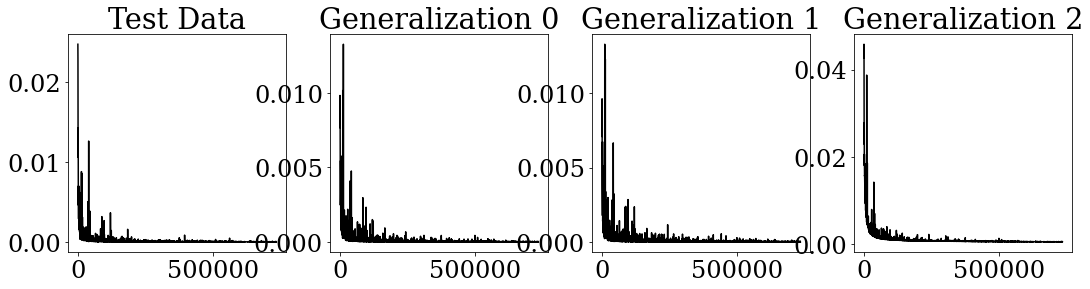

In [ ]:
sliced_iter = int(logged_iter * 0.5)

fig = plt.figure(1, figsize=(18, 4))
fig.clf()
x = np.array(logged_iterations)

# Training
y = logged_losses_tr
ax = fig.add_subplot(1, 4, 1)
ax.plot(x[0:len(y)], y, "k")
ax.set_title("Test Data") 

# Gen 0 loss.
y = losses_0_ge
ax = fig.add_subplot(1, 4, 2)
ax.plot(range(len(y)), y, "k")
ax.set_title("Generalization 0")

# Gen 1 Loss.
y = losses_1_ge
ax = fig.add_subplot(1, 4, 3)
ax.plot(range(len(y)), y, "k")
ax.set_title("Generalization 1") 

# Gen 2 Loss.
y = losses_2_ge
ax = fig.add_subplot(1, 4, 4)
ax.plot(range(len(y)), y, "k")
ax.set_title("Generalization 2") 



## Displacement Outputs


In [ ]:
font = {'family' : 'Verdana',
        'weight' : 'normal',
        'size'   : 24}
from matplotlib import rcParams
mpl.rc('font', **font)
lw = 4
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Tahoma']

input_gt = input_graph_2_ge[idx_0_ge]
target = target_2_ge[idx_0_ge]
sess_dict = test_values_2_ge.copy()
mesh = raw_2_ge[idx_0_ge][0]
material = raw_2_ge[idx_0_ge][2]
results = raw_2_ge[idx_0_ge][3]
ML_output = sess_dict["outputs"]
x,y = np.asarray(mesh.coords).T

uur via Nodes -  Error: avg 0.0145, max 0.7846, min -0.1778


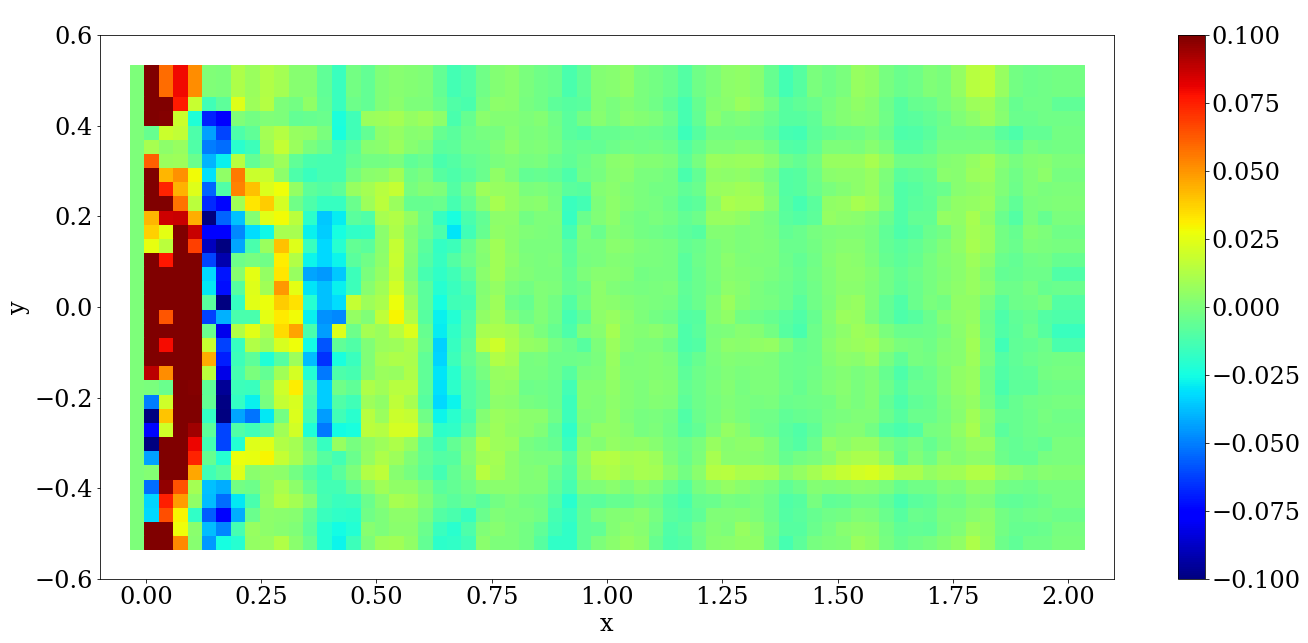

uur via Edges -  Error: avg 0.0077, max 0.6679, min -0.1192


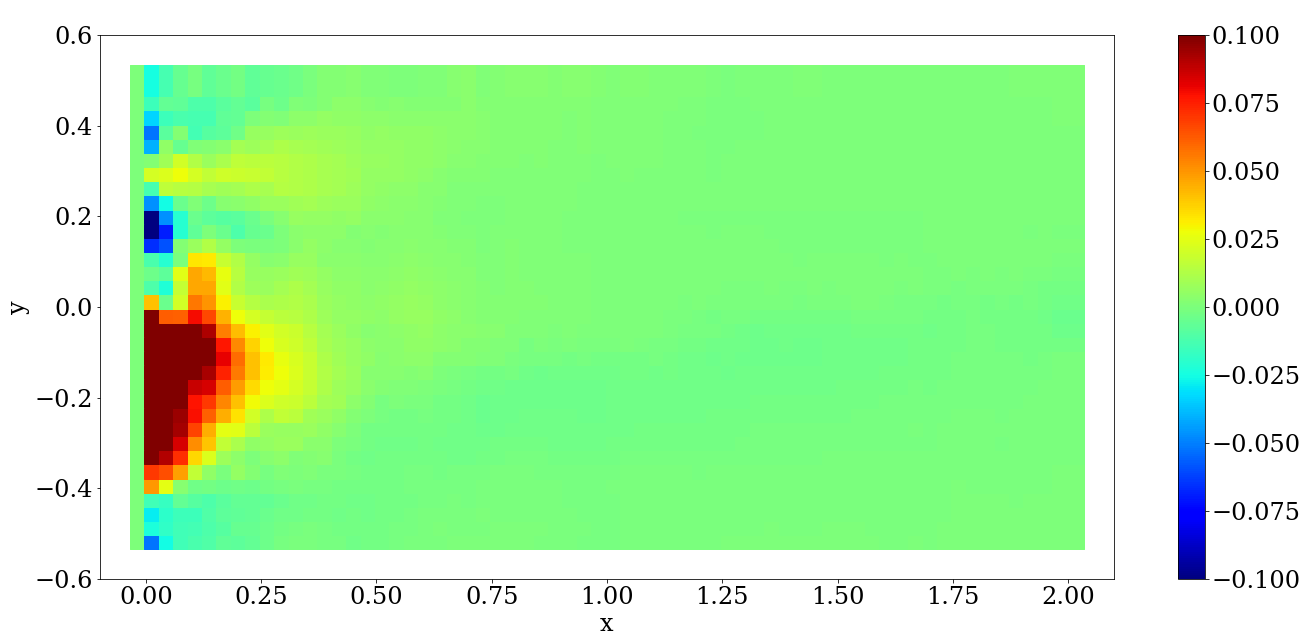

In [ ]:
size = 1e3
cap = 0.1

uur_fea = get_node_trajectories(sess_dict["target"].nodes,1, 0, 2)[0]
uur_ML = uur_from_nodes(input_gt, ML_output, target_stats)
err_tst, avg_err_tst, max_tst, min_tst  = get_disp_err(uur_fea, uur_ML)
print("uur via Nodes -  Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_tst, max_tst, min_tst))
plot_capped_nodal_vect(x,y,np.asarray(err_tst)," ", size, -cap, cap)

uur_ML = uur_from_edges(input_gt, ML_output,  target_stats)
err_tst, avg_err_tst, max_tst, min_tst  = get_disp_err(uur_fea, uur_ML)
print("uur via Edges -  Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_tst, max_tst, min_tst))
plot_capped_nodal_vect(x,y,np.asarray(err_tst)," ", size, -cap, cap)

# Convergence Study

In [ ]:
# LOAD A HIGH-FI EXAMPLE
with open('{}/Documents_Records/uur_known_240x120'.format(DIRECTORY), 'rb') as f :
  uur_known = dill.load(f)
m1_a = 240
m2_a = 120
m1_list = [24, 40, 48, 80, 120]
m2_list = [int(val/2) for val in m1_list]
m1p_list = [8, 8, 8, 8, 8]
m2p_list = [int(val/2) for val in m1p_list]
M1_list = [8, 8, 8, 8, 8]
M2_list = [int(val/2) for val in M1_list]


In [ ]:
elem_type = "quad" # "tri" or "quad"
bound_x = (0.0, 2.0)
bound_y = (-0.5, 0.5)
E = 200e9
v = 0.3

force_dofs = [0, 1]
force_vals = [0, -1e7]
body_force = [0.0, 0.0]
vol_frac_min_max = (1.0, 1.0)
density_min_max = (1.0, 1.0)
support_options = ["left_cantilever"] # ["left_cantilever", "right_cantilever", "dual_cantilever", "MBB"]
force_options = ["side_center"] # ["side_center", "side_bottom", "side_top", "top_center", "top_distributed"]
multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt = False, True, False, False
force_scale = (-1.0, 1.0)

batch_size_con = 1
refine_fact_con = (0.0, 0.0) 
coord_noise_min_max_con = (0.0, 0.0)
noise_type_con = "posi" 
multiscale_min_max_m1 = (4, 7) # must be at least 4
multiscale_min_max_m2 = (4, 7) # must be at least 4

raw_con, input_graph_list_con, simulated_graph_list_con, recovery_con = generate_convergence_data(
     M1_list, M2_list, m1p_list, m2p_list, m1_list, m2_list, refine_fact_con, vol_frac_min_max, density_min_max, noise_type_con, coord_noise_min_max_con,
    support_options, force_options, multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt,
     elem_type, bound_x, bound_y, E, v, force_vals, force_dofs, body_force,
     multiscale_min_max_m1, multiscale_min_max_m2, force_scale)  
initial_conditions_con, true_deformation_con = generate_raw_data(input_graph_list_con, simulated_graph_list_con ,
                                                                              batch_size_con + 1)

KUR_con = [item[-1] for item in recovery_con]
input_graph_con = sess.run(initial_conditions_con)
target_con = sess.run(true_deformation_con)
input_graph_con = normalize_input_list_GNN(input_graph_con,input_stats)
input_graph_con = trim_input_GNN(input_graph_con)

output_ops_con = model(initial_conditions_ph)


Stat mesh: 8 x 4 || Father mesh: 8 x 4 || Child mesh: 24 x 12 || Force Vals: 0.0000, -10000000.0000 || left_cantilever, side_center || (0.0, 2.0) x (-0.5, 0.5)
Projection Error: avg 0.1149, max 2.2090, min -0.3816
Pass:  0.0005365314179774032

Stat mesh: 8 x 4 || Father mesh: 8 x 4 || Child mesh: 40 x 20 || Force Vals: 0.0000, -10000000.0000 || left_cantilever, side_center || (0.0, 2.0) x (-0.5, 0.5)
Projection Error: avg 0.1442, max 5.8001, min -0.4381
Pass:  0.0005379554571809206

Stat mesh: 8 x 4 || Father mesh: 8 x 4 || Child mesh: 48 x 24 || Force Vals: 0.0000, -10000000.0000 || left_cantilever, side_center || (0.0, 2.0) x (-0.5, 0.5)
Projection Error: avg 0.1570, max 7.9212, min -0.4506
Pass:  0.0005382202071198404

Stat mesh: 8 x 4 || Father mesh: 8 x 4 || Child mesh: 80 x 40 || Force Vals: 0.0000, -10000000.0000 || left_cantilever, side_center || (0.0, 2.0) x (-0.5, 0.5)
Projection Error: avg 0.1975, max 17.8526, min -0.4745
Pass:  0.0005386999542381084

Stat mesh: 8 x 4 || Fa

## Convergence via L2

In [ ]:
start_time = time.time()
fea_uur = []
ml_uur = []
logged_elems = []
logged_L2_fea = []
logged_L2_ml = []
uur_lengths = []
logged_uur = []
logged_err_avg_fea = []
logged_err_max_fea = []
logged_err_min_fea = []
logged_err_avg_ml = []
logged_err_max_ml = []
logged_err_min_ml = []

for idx_con, (m1, m2) in enumerate(zip(m1_list, m2_list)) :

  feed_dict_con =  create_feed_dict(idx_con, input_graph_con, target_con, KUR_con,
                               initial_conditions_ph, true_deformation_ph, KUR_ph)
  test_values_con = sess.run({
        "target": true_deformation_ph,
        "outputs": output_ops_con
        }, feed_dict = feed_dict_con)
  
  
  s_0 = get_node_trajectories(test_values_con["target"].nodes,1, 0, 2)[0]
  m_0 = uur_from_edges(input_graph_con[idx_con], test_values_con["outputs"],  target_stats)
  fea_uur.append(s_0)
  ml_uur.append(m_0)

  ################################################################################################
  uur_b = project_known_displacement(m1_a, m2_a, m1, m2, uur_known)

  disp_b = (uur_b[..., 0]**2 + uur_b[..., 1]**2)**0.5
  disp_fea = (s_0[..., 0]**2 + s_0[..., 1]**2)**0.5
  disp_ml = (m_0[..., 0]**2 + m_0[..., 1]**2)**0.5
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    err_tst_fea = np.nan_to_num(np.abs(disp_b - disp_fea) / disp_b, posinf = 0, neginf =0)
    err_tst_ml = np.nan_to_num(np.abs(disp_b - disp_ml) / disp_b, posinf = 0, neginf =0)
  avg_err_fea = sum(err_tst_fea) / len(err_tst_fea)
  max_fea = err_tst_fea.max()
  min_fea = err_tst_fea.min()
  print("FEA Relative Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_fea, max_fea, min_fea))

  avg_err_ml = sum(err_tst_ml) / len(err_tst_ml)
  max_ml = err_tst_ml.max()
  min_ml = err_tst_ml.min()
  print("ML Relative Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_ml, max_ml, min_ml))

  L2_fea = np.linalg.norm(uur_b - s_0)
  L2_ml = np.linalg.norm(uur_b - m_0)

  logged_L2_fea.append(L2_fea)
  logged_L2_ml.append(L2_ml)
  logged_err_avg_fea.append(avg_err_fea)
  logged_err_max_fea.append(max_fea)
  logged_err_min_fea.append(min_fea)
  logged_err_avg_ml.append(avg_err_ml)
  logged_err_max_ml.append(max_ml)
  logged_err_min_ml.append(min_ml)
  logged_elems.append(m1*m2)
  uur_lengths.append((m1+1)*(m2+1))
  print(idx_con,':', m1, 'x', m2, end = ' | ')
  print("FEA: {:.4e}".format(L2_fea), end = " | ")
  print("ML: {:.4e}".format(L2_ml), '\n')


FEA Relative Error: avg 0.0128, max 0.0744, min 0.0000
ML Relative Error: avg 0.0189, max 0.1463, min 0.0000
0 : 24 x 12 | FEA: 1.5386e-04 | ML: 2.5384e-04 

FEA Relative Error: avg 0.0061, max 0.0668, min 0.0000
ML Relative Error: avg 0.0049, max 0.0655, min 0.0000
1 : 40 x 20 | FEA: 1.0862e-04 | ML: 1.0361e-04 

FEA Relative Error: avg 0.0046, max 0.0646, min 0.0000
ML Relative Error: avg 0.0016, max 0.0627, min 0.0000
2 : 48 x 24 | FEA: 9.5698e-05 | ML: 6.0091e-05 

FEA Relative Error: avg 0.0020, max 0.0569, min 0.0000
ML Relative Error: avg 0.0067, max 0.0573, min 0.0000
3 : 80 x 40 | FEA: 6.4481e-05 | ML: 3.0241e-04 

FEA Relative Error: avg 0.0009, max 0.0458, min 0.0000
ML Relative Error: avg 0.0170, max 0.4693, min 0.0000
4 : 120 x 60 | FEA: 4.1870e-05 | ML: 8.1945e-04 



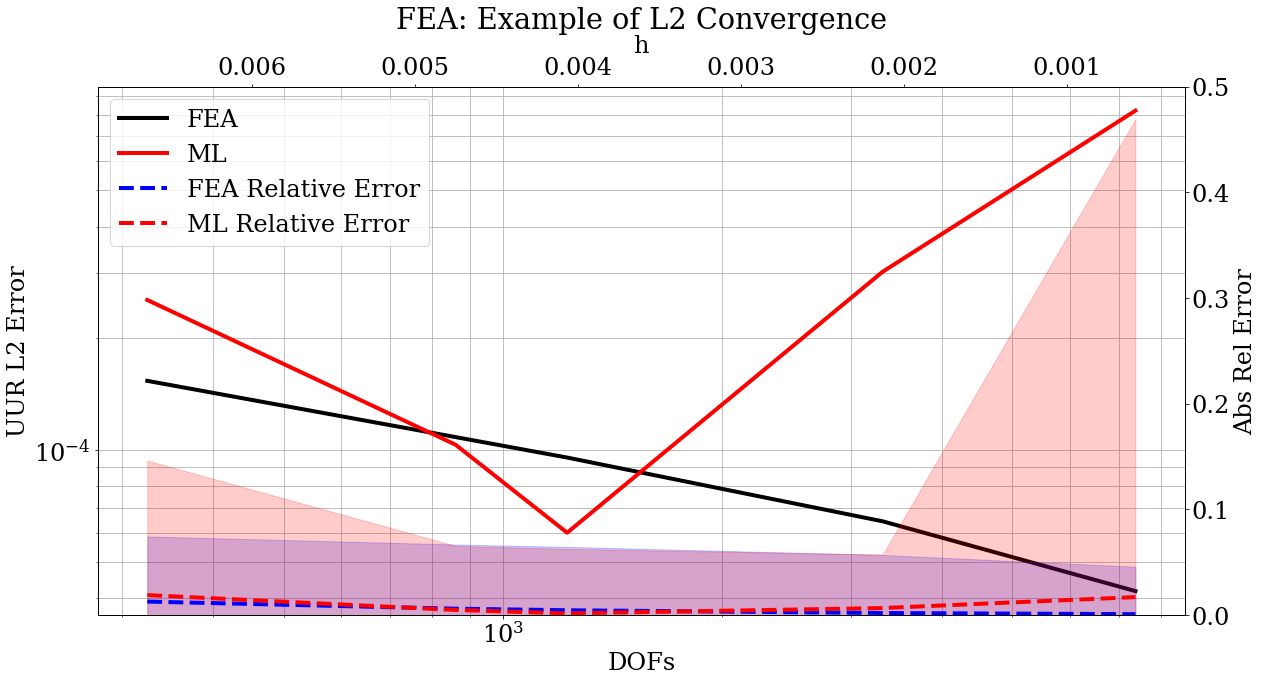

-0.4123256490385971
r^2 = 0.396


In [ ]:
o = 0
i = 10
h = 2/np.asarray(logged_elems)[o:i]
x = np.asarray(uur_lengths)[o:i]
y0 = np.asarray(logged_L2_fea)[o:i]
y1 = np.asarray(logged_L2_ml)[o:i]
avg_e_fea = np.asarray(logged_err_avg_fea)[o:i]
max_e_fea = np.asarray(logged_err_max_fea)[o:i]
min_e_fea = np.asarray(logged_err_min_fea)[o:i]
avg_e_ml = np.asarray(logged_err_avg_ml)[o:i]
max_e_ml = np.asarray(logged_err_max_ml)[o:i]
min_e_ml = np.asarray(logged_err_min_ml)[o:i]

################################################################
error_lim = 0.5
fea_err_color = "blue"
ml_err_color = "red"

fig = plt.figure(1, figsize=(50, 10))
font = {'family' : 'Verdana',
        'weight' : 'normal',
        'size'   : 24}
from matplotlib import rcParams
mpl.rc('font', **font)
lw = 4
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Tahoma']

# Convergence
ax = fig.add_subplot(1, 3, 1)
ax.grid(True, which = 'both')
ax.set_title("FEA: Example of L2 Convergence") 
ax.set_ylabel('UUR L2 Error')
ax.set_xlabel('DOFs')
plt.xscale("log")
plt.yscale("log")
line1 = ax.plot(x, y0, c = 'k', lw = lw, label = 'FEA', zorder = 10)
line2 = ax.plot(x, y1, c = 'r', lw = lw, label = 'ML', zorder = 10)
# Relative Error
ax1 = ax.twinx()
ax1.set_ylim([0, error_lim])
ax1.set_ylabel('Abs Rel Error')
line3 = ax1.plot(x, avg_e_fea, '--', c = fea_err_color, lw = lw, label = 'FEA Relative Error')
line4 = ax1.plot(x, avg_e_ml, '--', c = ml_err_color, lw = lw, label = 'ML Relative Error')
line5 = ax1.fill_between(x, min_e_fea, max_e_fea, color = fea_err_color, alpha = 0.2, label = "FEA Error Bounds")
line6 = ax1.fill_between(x, min_e_ml, max_e_ml, color = ml_err_color, alpha = 0.2, label = "ML Error Bounds")
# secax = ax.secondary_xaxis('top', 2/np.asarray(logged_elems)[o:i])
# secax.set_xlabel('angle [rad]')


# DOF
ax2 = ax.twiny()
ax2.set_xlabel('h')
ax2.set_xlim([h.max(), h.min()])

# Legend
lns = line1 + line2 + line3 + line4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
fig.tight_layout()
plt.show()

# Polyfit
m, b = np.polyfit(np.log10(x), np.log10(y0), 1)
print(m)



slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(y0), np.log10(y1))
print("r^2 = {:.3f}".format(r_value**2))